<a href="https://colab.research.google.com/github/vinurajd/google_collab_DL/blob/master/Classify_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import logging
import math
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,fname="flower_photos.tgz",extract=True)
base_dir = os.path.join(os.path.dirname(zip_file),"flower_photos")

zip_dir_base = os.path.dirname(base_dir)
!find $zip_dir_base -type d -print

228818944/228813984 [==============================] - 1s 0us/step
/root/.keras/datasets
/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/roses


In [4]:
class_names = ['roses','daisy','dandelion','sunflowers','tulips']


In [5]:
for cl in class_names:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
print(train_dir)

/root/.keras/datasets/flower_photos/train


In [8]:
BATCH_SIZE=100
IMG_SHAPE=150

In [9]:
image_gen=ImageDataGenerator(rescale=1./255,horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2935 images belonging to 5 classes.


In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [11]:
image_gen=ImageDataGenerator(rescale=1./255, 
                             zoom_range=0.5,
                             rotation_range=45,
                             horizontal_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             shear_range=0.2,
                             fill_mode='nearest')

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='sparse')

Found 2935 images belonging to 5 classes.


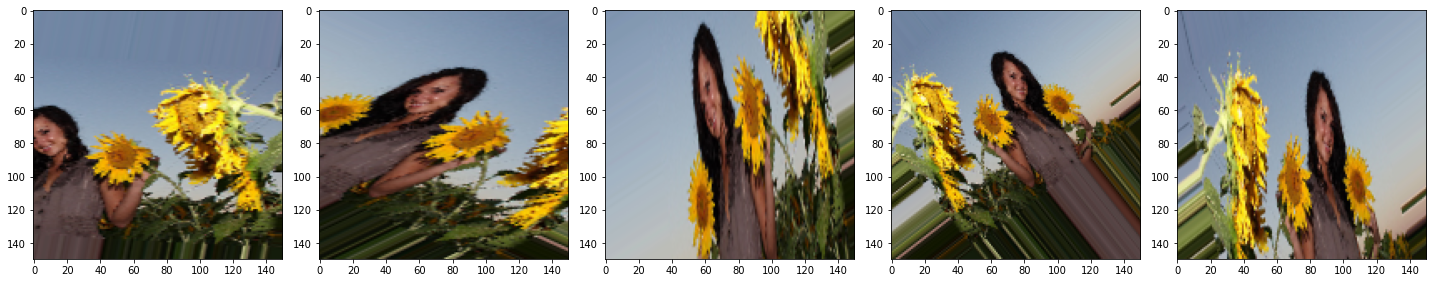

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 735 images belonging to 5 classes.


In [21]:
cnn_model = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv2D(32,3, padding='same',activation='relu',input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
                                        tf.keras.layers.MaxPooling2D((2,2)),

                                        tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2,2)),

                                        tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2,2)),

                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dropout(0.2),
                                        
                                        tf.keras.layers.Dense(512,activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        
                                        tf.keras.layers.Dense(5, activation = 'softmax')                     
])

In [22]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)            

In [23]:
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [24]:
epochs=30
history = cnn_model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/30
22/30 [=====================>........] - ETA: 5s - loss: 1.5815 - accuracy: 0.2829

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Traing and Validation loss')

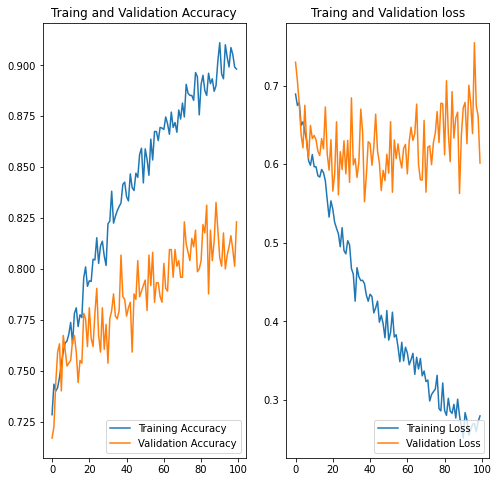

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epoch_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range,acc,label="Training Accuracy")
plt.plot(epoch_range,val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Traing and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epoch_range,loss,label="Training Loss")
plt.plot(epoch_range,val_loss,label="Validation Loss")
plt.legend(loc='lower right')
plt.title("Traing and Validation loss")
